詳細文檔內容請參考 [詳細文檔](https://github.com/jason90330/EdgeFinal/blob/main/README.md)

這支程式為示範使用 OpenVINO 環境進行單張照片推論使用，詳細訓練程式碼及其他影片推論 DEMO 請參考 [GitHub](https://github.com/jason90330/EdgeFinal)

程式執行前需要先設定為 GPU 執行環境(點擊 **Runtime -> Change Runtime type -> GPU**)





# 1.   Pull Github 專案


In [1]:
!git clone https://github.com/jason90330/EdgeFinal.git
%cd EdgeFinal
!dir

Cloning into 'EdgeFinal'...
remote: Enumerating objects: 322, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 322 (delta 131), reused 240 (delta 59), pack-reused 0
Receiving objects: 100% (322/322), 99.11 MiB | 25.68 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Checking out files: 100% (95/95), done.
/content/EdgeFinal
colab_inference.ipynb  demo_photo.ipynb      layers	  retina_face
config.py	       demo_video.py	     loss	  test.py
data		       deploy.py	     model	  train.py
dataset		       eval_kit		     models	  util
demo_camera_ir.py      face_embedding_model  __pycache__
demo_camera_rgb.py     inference.py	     README.md


In [2]:
!nvidia-smi

Wed Jun 23 13:55:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2. 安裝 OpenVINO 及相關套件

In [3]:
# 安裝 EfficientNet 套件
!pip install efficientnet_pytorch
# 取得OpenVINO 2021公開金錀
!wget https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 加入OpenVINO公開金錀到系統金錀群中
!apt-key add GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 建立更新安裝清單檔案
!touch /etc/apt/sources.list.d/intel-openvino-2021.list
# 將下載指令加入安裝清單中
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" >> /etc/apt/sources.list.d/intel-openvino-2021.list
# 更新系統
!apt update
# 安裝OpenVINO到虛擬機系統中
!apt install intel-openvino-dev-ubuntu18-2021.3.394
# 列出安裝路徑下內容進行確認
!ls /opt/intel
# 安裝OpenVINO套件
!pip install openvino

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=27080b2684a9f68733e7fa117a5b2acf003232771609e2f69bff004a1d6e15a9
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch
--2021-06-23 13:55:47--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021
Resolving apt.repos.intel.com (apt.repos.intel.com)... 23.14.14.19, 2a02:26f0:e600:589::4b23, 2a02:26f0:e600:58d::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|23.14.14.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘GPG-PUB-KEY-INTEL-OPENVINO-2021’

GPG-PUB-KEY-INTEL-O 100%[===================>]     939  --.-KB/s    in 0s      

2021-06-23 13:55:47 (39.3 MB/s) - ‘GPG-PUB-KEY-INTEL-OPENVINO-2021’ saved [939/939]

OK
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelea

# 3. Import 函式庫

In [4]:
import torch
import numpy as np
from torch import nn
from torch.nn import Parameter
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os.path as osp
import models
import time
from retina_face import config
from deploy import init_model
from models.efficientNet import MyEfficientNet
from openvino.inference_engine import IENetwork, IECore
from torchvision import transforms, utils
import cv2
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 4. 推論程式碼

In [5]:
def inferenceByIR(rgbImg):
    model_xml = "model/AFFECTNET_imbalance_10000/FP16/net_011.xml" #指定IR模型檔(*.xml)
    model_bin = "model/AFFECTNET_imbalance_10000/FP16/net_011.bin" #指定IR權重檔(*.bin)
    ie = IECore() #建立推論引擎
    # net = cv.dnn.readNetFromModelOptimizer(model_xml, model_bin) # 讀取IR檔

    # read model
    net = IENetwork(model=model_xml, weights=model_bin) #載入模型及權重
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    exec_net = ie.load_network(network = net, device_name = "CPU")
    n, c, h, w = net.inputs[input_blob].shape #1, 3, 224, 224
    net.batch_size =1

    # predict
    time_0 = time.clock()
    output = exec_net.infer(inputs={input_blob: rgbImg})[out_blob]
    time_1 = time.clock()
    output = torch.Tensor(output)
    probablity = torch.nn.functional.softmax(output, dim=-1).cpu().detach().numpy().copy()
    score = probablity#np.squeeze(score, 1)
    print("="*60)
    print("[INFO] Probabilities:")
    print(score[0])
    print("[INFO] Inference time = {:.4f} sec.".format(time_1 - time_0))
    return score

# 5. 取得一張網路上的圖像

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


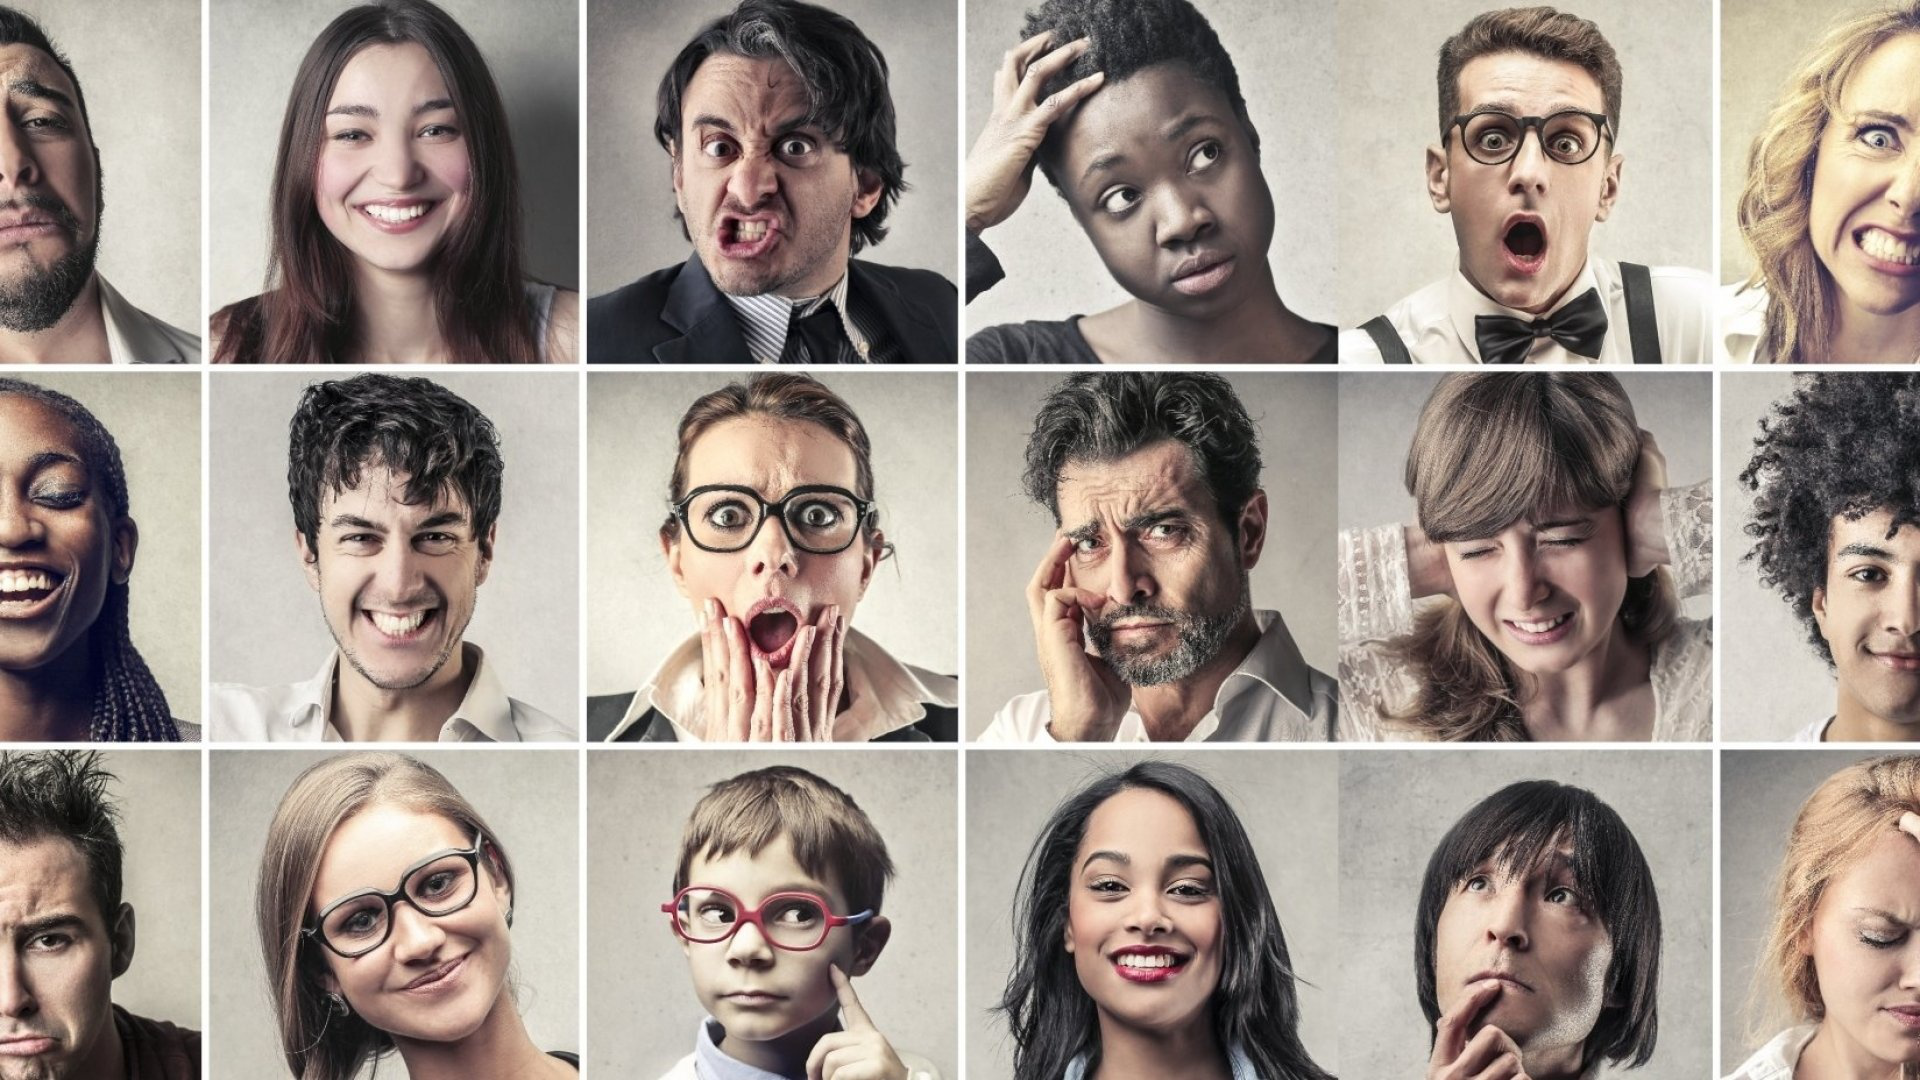

In [18]:
# 以OpenCV檢視輸入影像
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

# 從網路獲取一張影像
# file = requests.get("http://zahal-levy.com/wp-content/uploads/family-parents-grandparents-Morsa-Images-Taxi-56a906ad3df78cf772a2ef29.jpg")
# file = requests.get("https://4.bp.blogspot.com/-jTYm8ZrOLD0/WHjGDYUdOUI/AAAAAAAANpo/B-a1gnXf0EcmCEnBId2oZqHDIL98cZgcgCLcB/s1600/mixed%2Bemotion%2Bhindi%2Bshayari.jpg")
file = requests.get("https://www.incimages.com/uploaded_files/image/1920x1080/getty_511992708_2000200020009280684_374718.jpg")
# 將影像轉成OpenCV格式
img = cv2.imdecode(np.fromstring(file.content, np.uint8), 1)
cv2.imwrite('face.jpg',img)
# read data
RGBimg = Image.open('face.jpg').convert('RGB')
RGBimg

# 6. 資料前處理

In [19]:
from util.demo_utils import DemoUtils
retina_utils = DemoUtils()
RGBimg = np.array(RGBimg)
roiFaces,facialPoints,box_coords = retina_utils.Preprocess(RGBimg)

Loaded pretrained weights for efficientnet-b0


# 7. 辨識圖像

In [20]:
# 對應標籤
AffectName = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry', 'Contempt']

probs = []
emotions = []
transf = transforms.Compose([transforms.ToTensor()])
rgbImg = transf(RGBimg)
for face in roiFaces:
  face = transf(face)
  prob = inferenceByIR(face)
  probs.append(prob)
  emo_idx = np.argmax(prob)
  emo_name = AffectName[emo_idx]
  emotions.append(emo_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


[INFO] Probabilities:
[0.01999431 0.69710773 0.00651037 0.00284588 0.00339281 0.00341436
 0.002122   0.2646126 ]
[INFO] Inference time = 0.0335 sec.
[INFO] Probabilities:
[0.1774439  0.00515783 0.01679411 0.7315323  0.05943885 0.00172737
 0.00315473 0.00475084]
[INFO] Inference time = 0.0289 sec.
[INFO] Probabilities:
[0.02675879 0.00454722 0.01007848 0.470807   0.4603762  0.00472325
 0.01912894 0.00358019]
[INFO] Inference time = 0.0333 sec.
[INFO] Probabilities:
[0.06799892 0.00812345 0.5792084  0.02978545 0.10950599 0.04531168
 0.14565736 0.01440865]
[INFO] Inference time = 0.0318 sec.
[INFO] Probabilities:
[5.7276577e-04 9.8308760e-01 1.2883581e-03 4.3805847e-03 3.3133591e-03
 2.3914580e-03 1.7431476e-03 3.2227850e-03]
[INFO] Inference time = 0.0320 sec.
[INFO] Probabilities:
[0.14890291 0.00569006 0.13122909 0.38573834 0.282051   0.00884471
 0.03062552 0.00691836]
[INFO] Inference time = 0.0358 sec.
[INFO] Probabilities:
[0.00270899 0.9483761  0.00332569 0.01738762 0.00685952 0.00

# 8. 繪製結果並輸出

len(bboxes) = 14 | len(emotions) = 14
['Happy', 'Surprise', 'Surprise', 'Sad', 'Happy', 'Surprise', 'Happy', 'Happy', 'Angry', 'Surprise', 'Sad', 'Neutral', 'Sad', 'Happy']


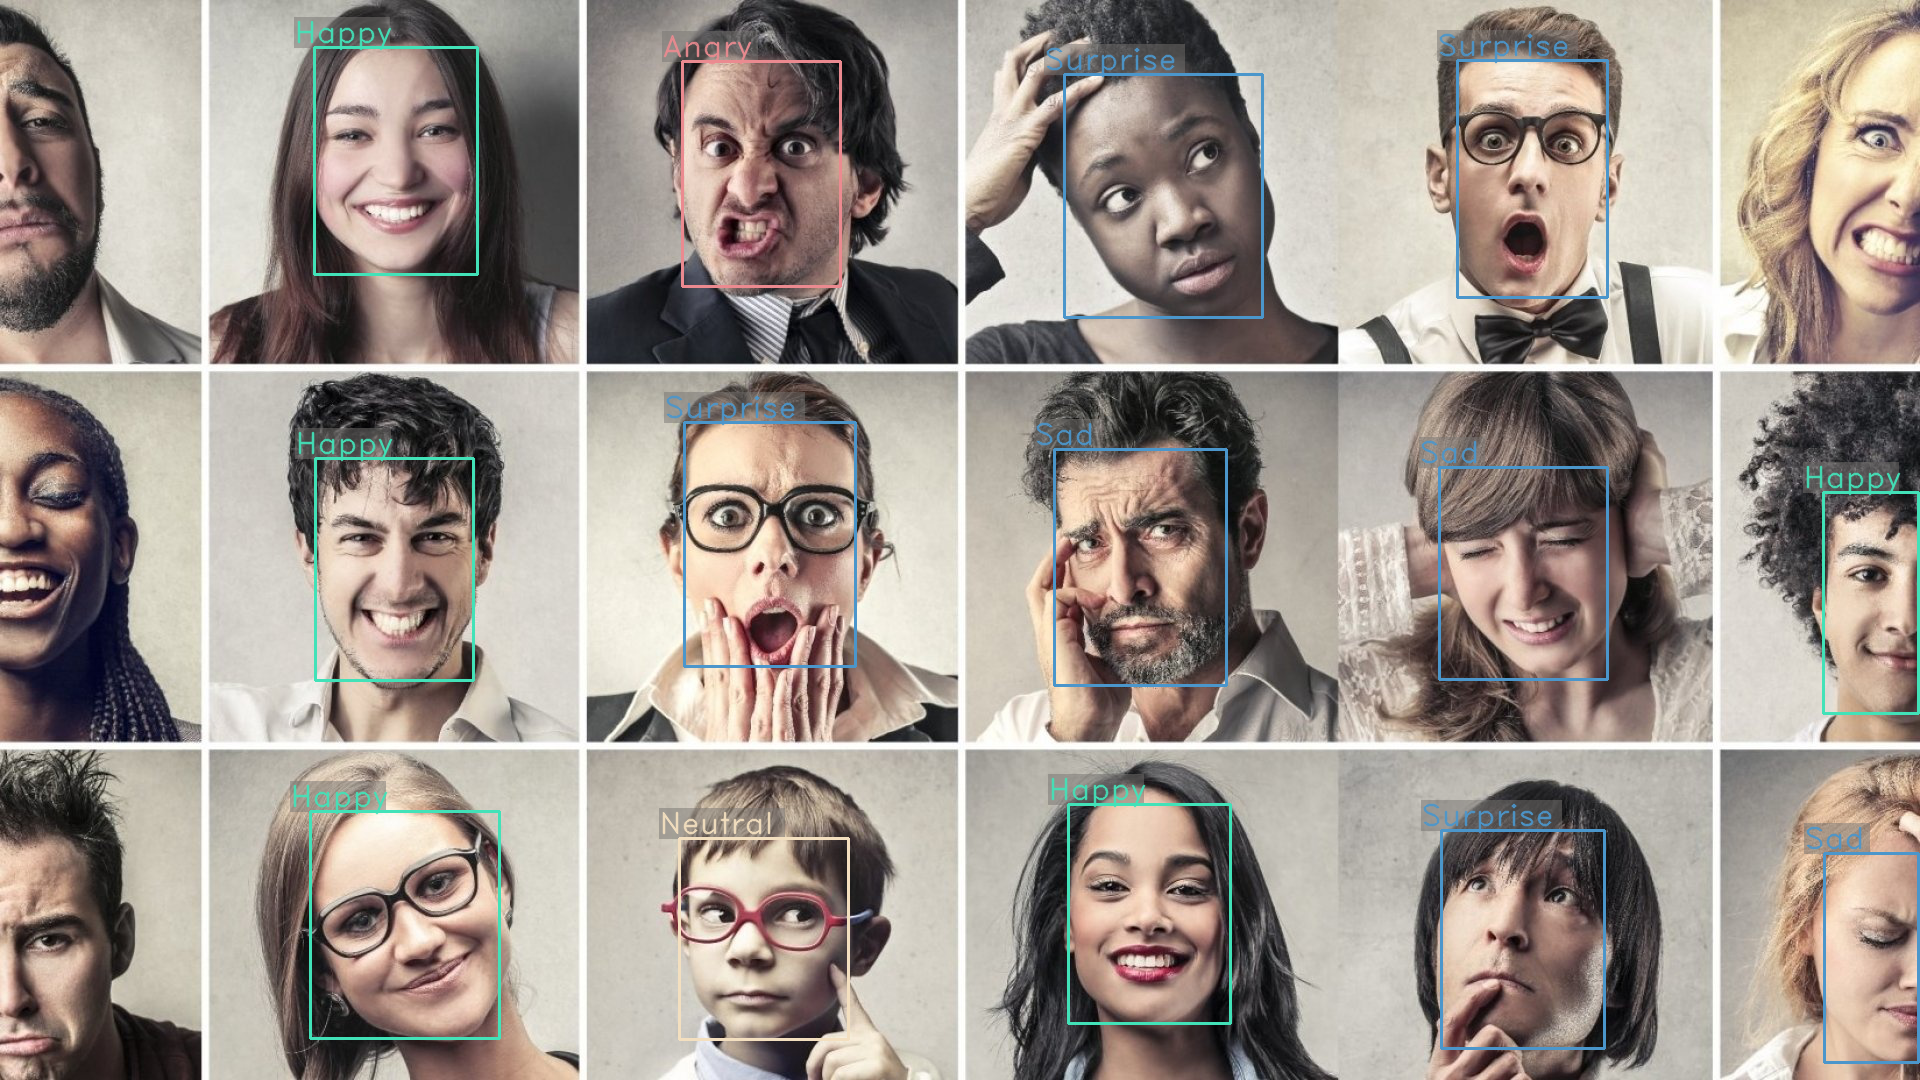

In [21]:
result = retina_utils.draw_faces_and_emotion(RGBimg, box_coords, emotions, probs)
vis_result = Image.fromarray(result)
vis_result